In [1]:
card_name = 'Cat_q2var_sys_test'

In [2]:
fit_real_data = False

# Import

In [155]:
import sys, os
from glob import glob
sys.path.append('../lib')
import itertools
import json
from IPython.display import IFrame

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from array import array

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from cebefo_style import Set_2D_colz_graphics
from gridVarQ2Plot import plot_gridVarQ2
from progressBar import ProgressBar

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

if fit_real_data:
    CMS_lumi.extraText = "Preliminary"
else:
    CMS_lumi.extraText = "Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


# Define binning

In [5]:
binning = {
    'q2'      : array('d', [-2, 1.5, 4, 6, 11]),
    'M2_miss' : [
        array('d', [-2.5] + list(np.arange(-1.8, 0.4, 0.5)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 1.6, 0.5)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 3.0, 0.5)) + [6] ),
        array('d', [-2.5] + list(np.arange(-1.8, 5.0, 0.5)) + [6] ),
    ],
    'Est_mu'  : [
        array('d', [0.5] + list(np.arange(0.8, 2.3, 0.1)) + [2.5] ),
        array('d', [0.5] + list(np.arange(0.8, 2.5, 0.1)) + [2.5] ),
        [20, 0.50, 2.500],
        [20, 0.50, 2.500],
    ]
}

# Create histograms file

In [6]:
file_loc = {
'mu'   : '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'tau'  : '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'Hc'   : '../data/cmsMC_private/BPH_Tag-B0_DmstHc-pD0bar-kp-Hc2mu_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root'
}
if fit_real_data:
    file_loc['data'] = '../data/cmsRD/ParkingBPH1/Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_191104_CAND.root'

In [7]:
dSet = {}
recreate = []
for n, filepath in file_loc.iteritems():
    print n
    fskimmed_name = '../data/_root/skimmed4combine/' + n + '.root'
    if os.path.isfile(fskimmed_name) and not n in recreate:
        dSet[n] = rtnp.root2array(fskimmed_name)
    else:
        tree = rt.TChain('outA/Tevts')
        for fn in glob(filepath):
            tree.Add(fn)
    
        pb = ProgressBar(maxEntry=tree.GetEntries())
        N_accepted_cand = []
        output = []
        for i_ev, ev in enumerate(tree):
            pb.show(i_ev)
            N_acc = 0
            
            aux = ev.trgMu_pt > 13
            aux &= ev.trgMu_sigdxy > 6.5
            if not aux: 
                continue
            
            for j in range(ev.pval_piK.size()):
                aux = ev.pval_piK[j] > 0.1
                aux &= ev.K_pt[j] > 0.8
                aux &= abs(ev.K_eta[j]) < 2.5
                aux &= ev.pi_pt[j] > 0.8
                aux &= abs(ev.pi_eta[j]) < 2.5
                aux &= abs(ev.mass_piK[j] - 1.86) < 0.04
                if not aux: 
                    continue
                
                aux = ev.pis_pt[j] > 0.5
                aux &= ev.pval_D0pis[j] > 0.1
                aux &= abs(ev.mass_D0pis[j] - 2.01) < 0.03
                aux &= ev.sigdxy_pis_PV[j] > 2
                aux &= ev.mass_D0pis[j] < ev.mass_piK[j] + 0.16
                aux &= ev.pval_D0pismu[j] > 0.1
                aux &= ev.cos_D0pismu_PV[j] > 0.99
                aux &= ev.q2_D0pismu[j] > binning['q2'][0]
                aux &= ev.q2_D0pismu[j] < binning['q2'][-1]
                if not aux: 
                    continue
                    
                N_acc += 1
                aux = (ev.q2_D0pismu[j], ev.Est_mu_D0pismu[j], ev.M2_miss_D0pismu[j])
                if not n == 'data':
                    aux += (ev.MC_B_pt, ev.MC_B_eta)
                if n == 'tau' or n == 'mu':
                    aux += (
                           ev.wh_CLNCentral,
                           ev.wh_CLNR0Down,
                           ev.wh_CLNR0Up,
                           ev.wh_CLNR1Down,
                           ev.wh_CLNR1Up,
                           ev.wh_CLNR2Down,
                           ev.wh_CLNR2Up,
                           ev.wh_CLNRhoSqDown,
                           ev.wh_CLNRhoSqUp,
                    )
                
                output.append(aux)
            
            if N_acc > 0:
                N_accepted_cand.append(N_acc)
                
        leafs_names = ['q2', 'Est_mu', 'M2_miss']
        if not n == 'data':
            leafs_names += ['MC_B_pt', 'MC_B_eta']
        if n == 'tau' or n == 'mu':
            leafs_names += ['wh_CLNCentral', 'wh_CLNR0Down', 'wh_CLNR0Up', 'wh_CLNR1Down', 'wh_CLNR1Up', 'wh_CLNR2Down', 'wh_CLNR2Up', 'wh_CLNRhoSqDown', 'wh_CLNRhoSqUp']

        dtypes = []
        for nl in leafs_names:
            dtypes.append((nl, np.float32))
            
        dSet[n] = np.array(output, dtype=dtypes)
        if not os.path.isdir(os.path.dirname(fskimmed_name)):
            os.makedirs(os.path.dirname(fskimmed_name))
        rtnp.array2root(dSet[n], fskimmed_name, treename='Tevts', mode='RECREATE')
        
    aux = dSet[n].dtype.fields.keys()[0]
    print 'Events:', dSet[n][aux].shape[0]
    print ''

mu
Events: 23260

tau
Events: 3267

Hc
Events: 905



In [8]:
class PTCalibration:
    def __init__(self, calibration_dic=None, calibration_file=None):
        if not calibration_dic is None:
            self.calibration_dic = calibration_dic
            d = calibration_dic
        elif not calibration_file is None:
            d = {}
            lines = open(calibration_file, 'r').readlines()
            keys = lines[0][1:-1].split('\t')
            for k in keys: d[k] = []
            
            for l in lines[1:]:
                l = l[:-1]
                v = l.split('\t')
                for i in range(len(v)):
                    d[keys[i]].append(float(v[i]))
            
            self.calibration_dic = d
        else:
            raise
        
        self.f = {}
        self.f['C'] = interp1d(d['pt'], d['w'], 
                               fill_value=(d['w'][0], d['w'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
        self.f['Up'] = interp1d(d['pt'], d['wUp'], 
                               fill_value=(d['wUp'][0], d['wUp'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
        self.f['Down'] = interp1d(d['pt'], d['wDown'], 
                               fill_value=(d['wDown'][0], d['wDown'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
cal_pT = PTCalibration(calibration_file='../data/calibration/B02JPsiKst_pt.txt')

In [9]:
histo = {}
for i_q2 in range(len(binning['q2'])-1):
    q2_l = binning['q2'][i_q2]
    q2_h = binning['q2'][i_q2 + 1]

    for var in ['M2_miss', 'Est_mu']:
        cat_name = var+'_q2bin'+str(i_q2)
        histo[cat_name] = {}
        for k,d in dSet.iteritems():          
            q2_bin = np.logical_and(d['q2'] > q2_l, d['q2'] < q2_h)
            
            if k == 'data':
                histo[cat_name][k] = create_TH1D(d[var][q2_bin], 
                                                 name='data_obs', title='Data Obs',
                                                 binning=binning[var][i_q2],
                                                 opt='underflow,overflow'
                                                )
            elif k in ['mu', 'tau', 'Hc']:
                for k_wpT in ['C', 'Up', 'Down']:
                    h_name = k
                    if k_wpT != 'C':
                        h_name += '__B0pT' + k_wpT
                        
                    w = cal_pT.f[k_wpT](d['MC_B_pt'][q2_bin])
                    
                    norm = np.sum(cal_pT.f[k_wpT](d['MC_B_pt']))
                    h = create_TH1D(d[var][q2_bin], name=h_name, title=h_name, 
                                    binning=binning[var][i_q2], 
                                    opt='underflow,overflow',
                                    weights=w,
                                    scale_histo=1./norm,
                                   )
                    
#                     N = d['MC_B_pt'][sel_q2].shape[0]
#                     p_max = 1 - np.power(0.68/2., 1./N)
#                     for i in range(1, h.binning[0]+1):
#                         if h.GetBinError(i) == 0:
#                             h.SetBinError(i, p_max)
                    histo[cat_name][h_name] = h

Generate Pseudo-data

In [10]:
rawR_exp = 0.1
f_Hc = 0.01

if fit_real_data:
    from lumi_utilities import getLumiReport
    lumi_tot, lumi_dic = getLumiReport(glob(file_loc['data']))
else:    
    lumi_tot = 2. #fb-1
    N_exp = 1e5*lumi_tot/5.0
    N_B2mu_inj = N_exp*(1-f_Hc)/(1+rawR_exp)

    n_mu = np.random.poisson(lam=N_B2mu_inj)
    w_mu = []
    idx_mu = []
    print('Generating pseudo mu')
    pb = ProgressBar(n_mu)
    while np.sum(w_mu) < n_mu:
        pb.show(np.sum(w_mu))
        i = np.random.randint(0, dSet['mu']['q2'].shape[0], size=(1, ))[0]
        w = cal_pT.f['C'](dSet['mu']['MC_B_pt'][i])
        idx_mu.append(i)
        w_mu.append(w)
    pb.show(n_mu-1)

    n_tau = np.random.poisson(lam=N_B2mu_inj*rawR_exp)
    w_tau = []
    idx_tau = []
    print('Generating pseudo tau')
    pb = ProgressBar(n_tau)
    while np.sum(w_tau) < n_tau:
        pb.show(np.sum(w_tau))
        i = np.random.randint(0, dSet['tau']['q2'].shape[0], size=(1, ))[0]
        w = cal_pT.f['C'](dSet['tau']['MC_B_pt'][i])
        idx_tau.append(i)
        w_tau.append(w)
    pb.show(n_tau-1)
    
    n_Hc = np.random.poisson(lam=N_exp*f_Hc)
    w_Hc = []
    idx_Hc = []
    print('Generating pseudo Hc')
    pb = ProgressBar(n_Hc)
    while np.sum(w_Hc) < n_Hc:
        pb.show(np.sum(w_Hc))
        i = np.random.randint(0, dSet['Hc']['q2'].shape[0], size=(1, ))[0]
        w = cal_pT.f['C'](dSet['Hc']['MC_B_pt'][i])
        idx_Hc.append(i)
        w_Hc.append(w)
    pb.show(n_Hc-1)

    pseudo_data = {}
    pseudo_w = np.array(w_mu + w_tau + w_Hc)
    for var in binning.keys():
        pseudo_data[var] = np.concatenate((dSet['mu'][var][idx_mu], 
                                           dSet['tau'][var][idx_tau],
                                           dSet['Hc'][var][idx_Hc],
                                          ))

    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]

        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)

            sel = np.logical_and(pseudo_data['q2'] > q2_l, pseudo_data['q2'] < q2_h)
            
            h = create_TH1D(pseudo_data[var][sel], 
                            name='data_obs', title='data obs',
                            binning=binning[var][i_q2],
                            opt='underflow,overflow',
                            weights=pseudo_w[sel]
                           )
            h.Sumw2(0)
            for i in range(1, h.GetNbinsX()+1):
                h.SetBinContent(i, round(h.GetBinContent(i)))
            h.Sumw2()
            histo[cat_name]['data'] = h

    print n_mu, n_tau, n_Hc
    print 'r_toy = {:.2f}%'.format(100.*n_tau/n_mu)

Generating pseudo mu
[####################]  100% - Tot. time: 206.4 s
Generating pseudo tau
[####################]  100% - Tot. time: 3.0 s
Generating pseudo Hc
[####################]  100% - Tot. time: 0.1 s
36017 3544 396
r_toy = 9.84%


In [11]:
N_data = 0
N_mu = 0
N_tau = 0
N_Hc = 0
for k, h_dic in histo.iteritems():
    if 'Est_mu' in k:
        N_data += h_dic['data'].Integral()
        N_mu += h_dic['mu'].Integral()
        N_tau += h_dic['tau'].Integral()
        N_Hc += h_dic['Hc'].Integral()
N_B2mu_exp = N_data*(1-f_Hc)/(1+rawR_exp)

print 'Number of data events: {:.0f}'.format(N_data)
print 'Total norm'
print 'Mu: {:.3f}'.format(N_mu)
print 'Tau: {:.3f}'.format(N_tau)
print 'Hc: {:.3f}'.format(N_Hc)

Number of data events: 39954
Total norm
Mu: 1.000
Tau: 1.000
Hc: 1.000


In [12]:
histo_file_dir = '../data/_root/histos4combine/'
if not os.path.isdir(histo_file_dir):
    os.makedirs(histo_file_dir)
histo_file_loc = {}
for cat_name, h_dic in histo.iteritems():
    histo_file_loc[cat_name] = histo_file_dir+'{}_{}.root'.format(card_name, cat_name)
    tf = rt.TFile(histo_file_loc[cat_name], 'recreate')
    for v in h_dic.values():
        v.Write()
    tf.Close()

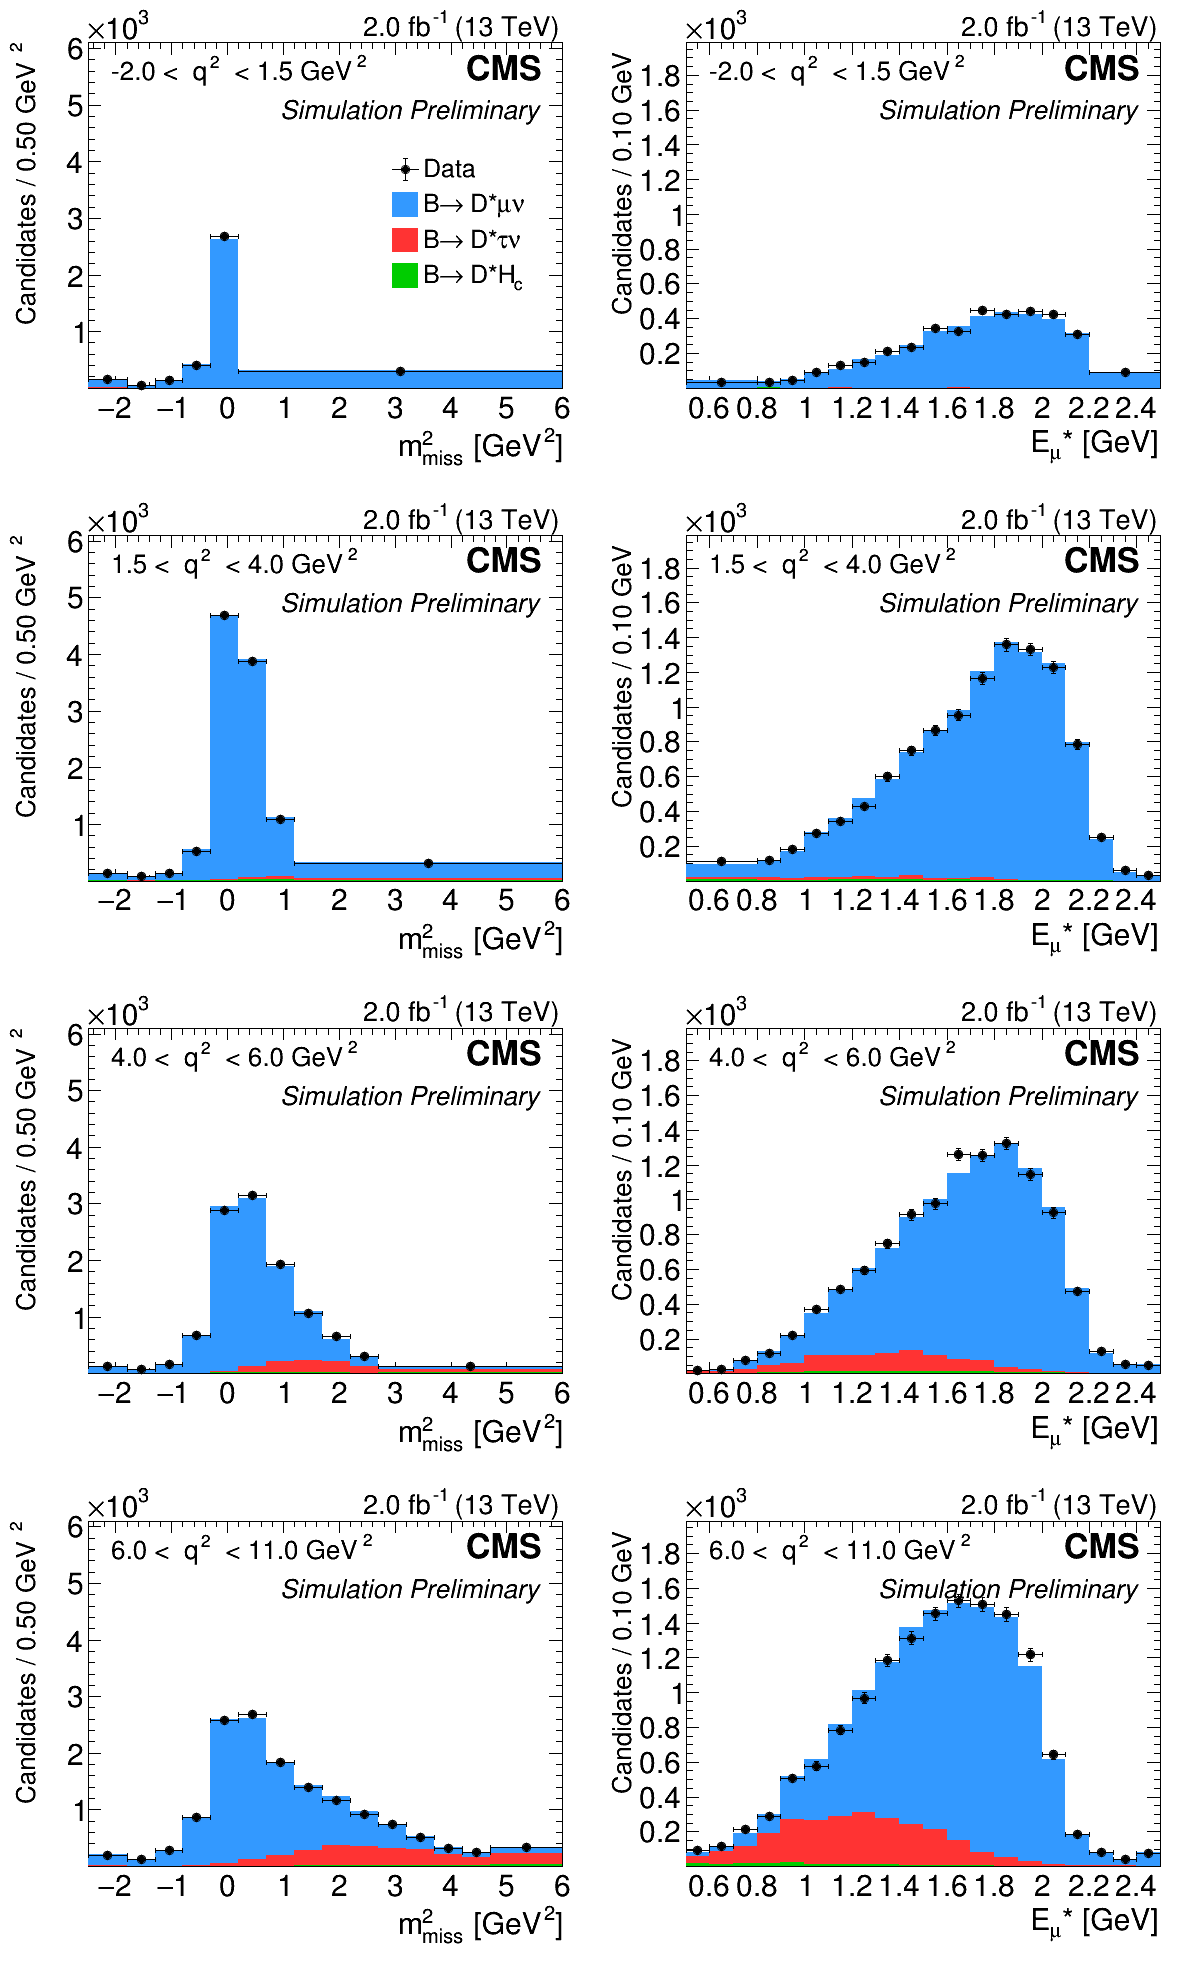

In [13]:
CMS_lumi.integrated_lumi = lumi_tot
scale_dic = {
    'tau': N_B2mu_exp*rawR_exp, 
    'mu' : N_B2mu_exp,
    'Hc' : N_B2mu_exp*(1+rawR_exp)*f_Hc/(1-f_Hc)
            }

c = plot_gridVarQ2(CMS_lumi, binning, histo, scale_dic)

# for i in range(1, 1+2*binning['q2'][0]):
#     p = c.cd(i)
#     p.SetLogy()

# Write the card

In [104]:
sig_processes = ['tau', 'mu']
bkg_processes = ['Hc']
processes = sig_processes + bkg_processes
categories = np.sort([k for k in histo.keys() if not '__' in k])

In [105]:
card_location = 'cards/{}.txt'.format(card_name)
fc = open(card_location, 'w')

In [109]:
# number of different categories
card = 'imax *\n'
# number of processes minus one
card += 'jmax {}\n'.format(len(processes)-1)
# number of nuissance parameters
card += 'kmax *\n'
card += '-------------------------------\n'

# shape file location
for k in categories:
    card += 'shapes * {} {} $PROCESS $PROCESS__$SYSTEMATIC\n'.format(k, histo_file_loc[k])
card += '-------------------------------\n'

# number of events observed
card += 'bin ' + ' '.join(categories) + '\n'
obs = map(lambda k: '{:.0f}'.format(histo[k]['data'].Integral()), categories)
obs = ' '.join(obs)
card += 'observation ' + obs + '\n'
card += '-------------------------------\n'


# MC expected events
aux_bin = ''
aux_proc_name = ''
aux_proc_id = ''
aux_proc_rate = ''
for c, p in itertools.product(categories, processes):
    aux_bin += ' '+c
    aux_proc_name += ' '+p
    aux_proc_id += ' '+str(np.argmax(np.array(processes) == p))
    aux_proc_rate += ' {}'.format(histo[c][p].Integral())
    
card += 'bin' + aux_bin + '\n'
card += 'process' + aux_proc_name + '\n'
# Zero or negative for sig and positive for bkg
card += 'process' + aux_proc_id + '\n'
# Expected rate
card += 'rate' + aux_proc_rate + '\n'
card += '-------------------------------\n'

Add additional rate parameters

In [110]:
card += 'N_B2mu rateParam * tau {:.1f} [0,{:.0f}]\n'.format(scale_dic['mu'], 1.2*N_data)
card += 'N_B2mu rateParam * mu {:.1f} [0,{:.0f}]\n'.format(scale_dic['mu'], 1.2*N_data)
card += 'N_B2DstHc rateParam * Hc {:.1f} [0,{:.0f}]\n'.format(scale_dic['Hc'], 1.2*N_data)
card += '-------------------------------\n'

Systematics

In [111]:
aux_B0pT = ''
for c, p in itertools.product(categories, processes):
    if p in ['tau', 'mu', 'Hc']:
        aux_B0pT += ' 1.'
    else:
        aux_B0pT += ' -'
card += 'B0pT shape' + aux_B0pT + '\n'

MC statistic systematics

In [112]:
card += '* autoMCStats 0 1 1\n'
card += '-------------------------------\n'

In [113]:
print card

imax *
jmax 2
kmax *
-------------------------------
shapes * Est_mu_q2bin0 ../data/_root/histos4combine/Cat_q2var_sys_test_Est_mu_q2bin0.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2bin1 ../data/_root/histos4combine/Cat_q2var_sys_test_Est_mu_q2bin1.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2bin2 ../data/_root/histos4combine/Cat_q2var_sys_test_Est_mu_q2bin2.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2bin3 ../data/_root/histos4combine/Cat_q2var_sys_test_Est_mu_q2bin3.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2bin0 ../data/_root/histos4combine/Cat_q2var_sys_test_M2_miss_q2bin0.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2bin1 ../data/_root/histos4combine/Cat_q2var_sys_test_M2_miss_q2bin1.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2bin2 ../data/_root/histos4combine/Cat_q2var_sys_test_M2_miss_q2bin2.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2bin3 ../data/_root/histos4combine/Cat_q2var_sys_test_M2_miss_q2bin3.root $P

In [114]:
fc.write(card)
fc.close()

### Create output directory

In [115]:
outdir = 'results/' + card_name

if os.path.isdir(outdir):
    os.system('rm -rf ' + outdir)
os.system('mkdir ' + outdir);

# Run Combine

## Create the workspace

In [116]:
cmd = 'text2workspace.py ' + card_location 
cmd += ' -o ' + card_location.replace('.txt', '.root')
cmd += ' --no-b-only'
cmd += ' --verbose 1'
# cmd += ' --no-wrappers'
os.system(cmd)

0

Channel Est_mu_q2bin0 will use autoMCStats with settings: event-threshold=0, include-signal=1, hist-mode=1
Analysing bin errors for: prop_binEst_mu_q2bin0
Poisson cut-off: 0
Bin        Contents        Error           Notes                         
0          46.482153       9.317600        total sum                     
0          25.000000       5.000000        Unweighted events, alpha=1.859286
  => Total parameter prop_binEst_mu_q2bin0_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          56.776836       18.375606       total sum                     
1          10.000000       3.162278        Unweighted events, alpha=5.677684
  => Total parameter prop_binEst_mu_q2bin0_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
2          58.631949       13.898970       total sum                     
2          18.000000       4.242641        Unweighted events, alpha=3.

Creating pdfs for individual modes (8): .    1.    2.    3.    4.    5.    6.    7.    8done.
Importing combined pdf model_s


### Run the Maximum Likelyhood fit

In [226]:
cmd = 'combine'
cmd += ' -M FitDiagnostics'
cmd += ' --robustFit 1'
cmd += ' --skipBOnlyFit'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r={:.2f}'.format(rawR_exp)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu,N_B2DstHc'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --saveShapes --saveWithUncertainties'
cmd += ' --plots'
cmd += ' --verbose 1'

print cmd
os.system(cmd)
os.system('mv combine_logger.out ' + outdir + '/')
os.system('mv ./*.root ' + outdir + '/')

combine -M FitDiagnostics --robustFit 1 --skipBOnlyFit -d cards/Cat_q2var_sys_test.root -D data_obs --X-rtd MINIMIZER_analytic --setParameters r=0.10 --setParameterRanges r=0.001,1 --trackParameters N_B2mu,N_B2DstHc -n Cat_q2var_sys_test --out results/Cat_q2var_sys_test --saveShapes --saveWithUncertainties --plots --verbose 1


0

 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is FitDiagnostics
>>> random number generator seed is 123456
Turning on runtime-define MINIMIZER_analytic
 PDF CHECKING 
--- RooAbsArg ---
  Value State: DIRTY
  Shape State: DIRTY
  Attributes:  [SnapShot_ExtRefClone,forceGenBinned] 
  Address: 0x83ad9c0
  Clients: 
    (0x847fe10,V-) RooSimultaneousOpt::model_s "model_s"
  Servers: 
    (0x83aeff0,V-) RooRealSumPdf::pdf_binEst_mu_q2bin0_nuis ""
    (0x8361700,V-) RooProdPdf::pdfbins_binEst_mu_q2bin0 ""
    (0x80f28c0,V-) SimpleGaussianConstraint::B0pT_Pdf "B0pT_Pdf"
  Proxies: 
    !pdfs -> 
      1)                   B0pT_Pdf
      2)  pdf_binEst_mu_q2bin0_nuis
      3)   pdfbins_binEst_mu_q2bin0
--- RooAbsReal ---

  Plot label is "pdf_binEst_mu_q2bin0"
--- RooAbsPdf ---
Cached value = 0
DataStore Est_mu_q2bin0 (Est_mu_q2bin0)
  Contains 20 entries
  Observables: 
    1)  CMS_th1x = 19.

Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/cards/Cat_q2var_sys_test.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
Error in <TList::Clear>: A list is accessing an object (0x870d64c) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x870d8f4) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x870db9c) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x870de44) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x870e0ec) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x870e394) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x870e63c) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing

In [167]:
cmd = 'python diffNuisances.py '.format(os.environ['CMSSW_BASE'])
cmd += glob(outdir + '/fitDiagnostics{}.root'.format(card_name))[0]
cmd += ' --skipFitB'
cmd += ' -g {}/nuisance_pull.root'.format(outdir)
print cmd
os.system(cmd)

python diffNuisances.py results/Cat_q2var_sys_test/fitDiagnosticsCat_q2var_sys_test.root --skipFitB -g results/Cat_q2var_sys_test/nuisance_pull.root


0

diffNuisances run on results/Cat_q2var_sys_test/fitDiagnosticsCat_q2var_sys_test.root, at 2019-11-15 01:34:11.949513 with the following options ... {'absolute_values': False, 'show_all_parameters': False, 'format': 'text', 'stol2': 0.5, 'pullDef': '', 'vtol': 0.3, 'stol': 0.1, 'plotfile': 'results/Cat_q2var_sys_test/nuisance_pull.root', 'skipFitB': True, 'vtol2': 2.0, 'poi': 'r'}

name                                              b-only fit            s+b fit         rho
B0pT                                          ! -0.02, 0.10!     ! -0.02, 0.10!       -0.08
prop_binEst_mu_q2bin0_bin0                       -0.98, 0.61        -0.98, 0.61       +0.08
prop_binEst_mu_q2bin0_bin1                       -0.52, 0.61        -0.52, 0.61       +0.10
prop_binEst_mu_q2bin0_bin10                      +0.73, 0.63        +0.73, 0.63       +0.02
prop_binEst_mu_q2bin0_bin11                      -0.35, 0.64        -0.35, 0.64       +0.02
prop_binEst_mu_q2bin0_bin12                      +0.32, 0.64    

r = 9.1 +0.6/-0.6 %
N_B2mu = 36040
N_B2DstHc = 669
results/Cat_q2var_sys_test/fitDiagnosticsCat_q2var_sys_test.root




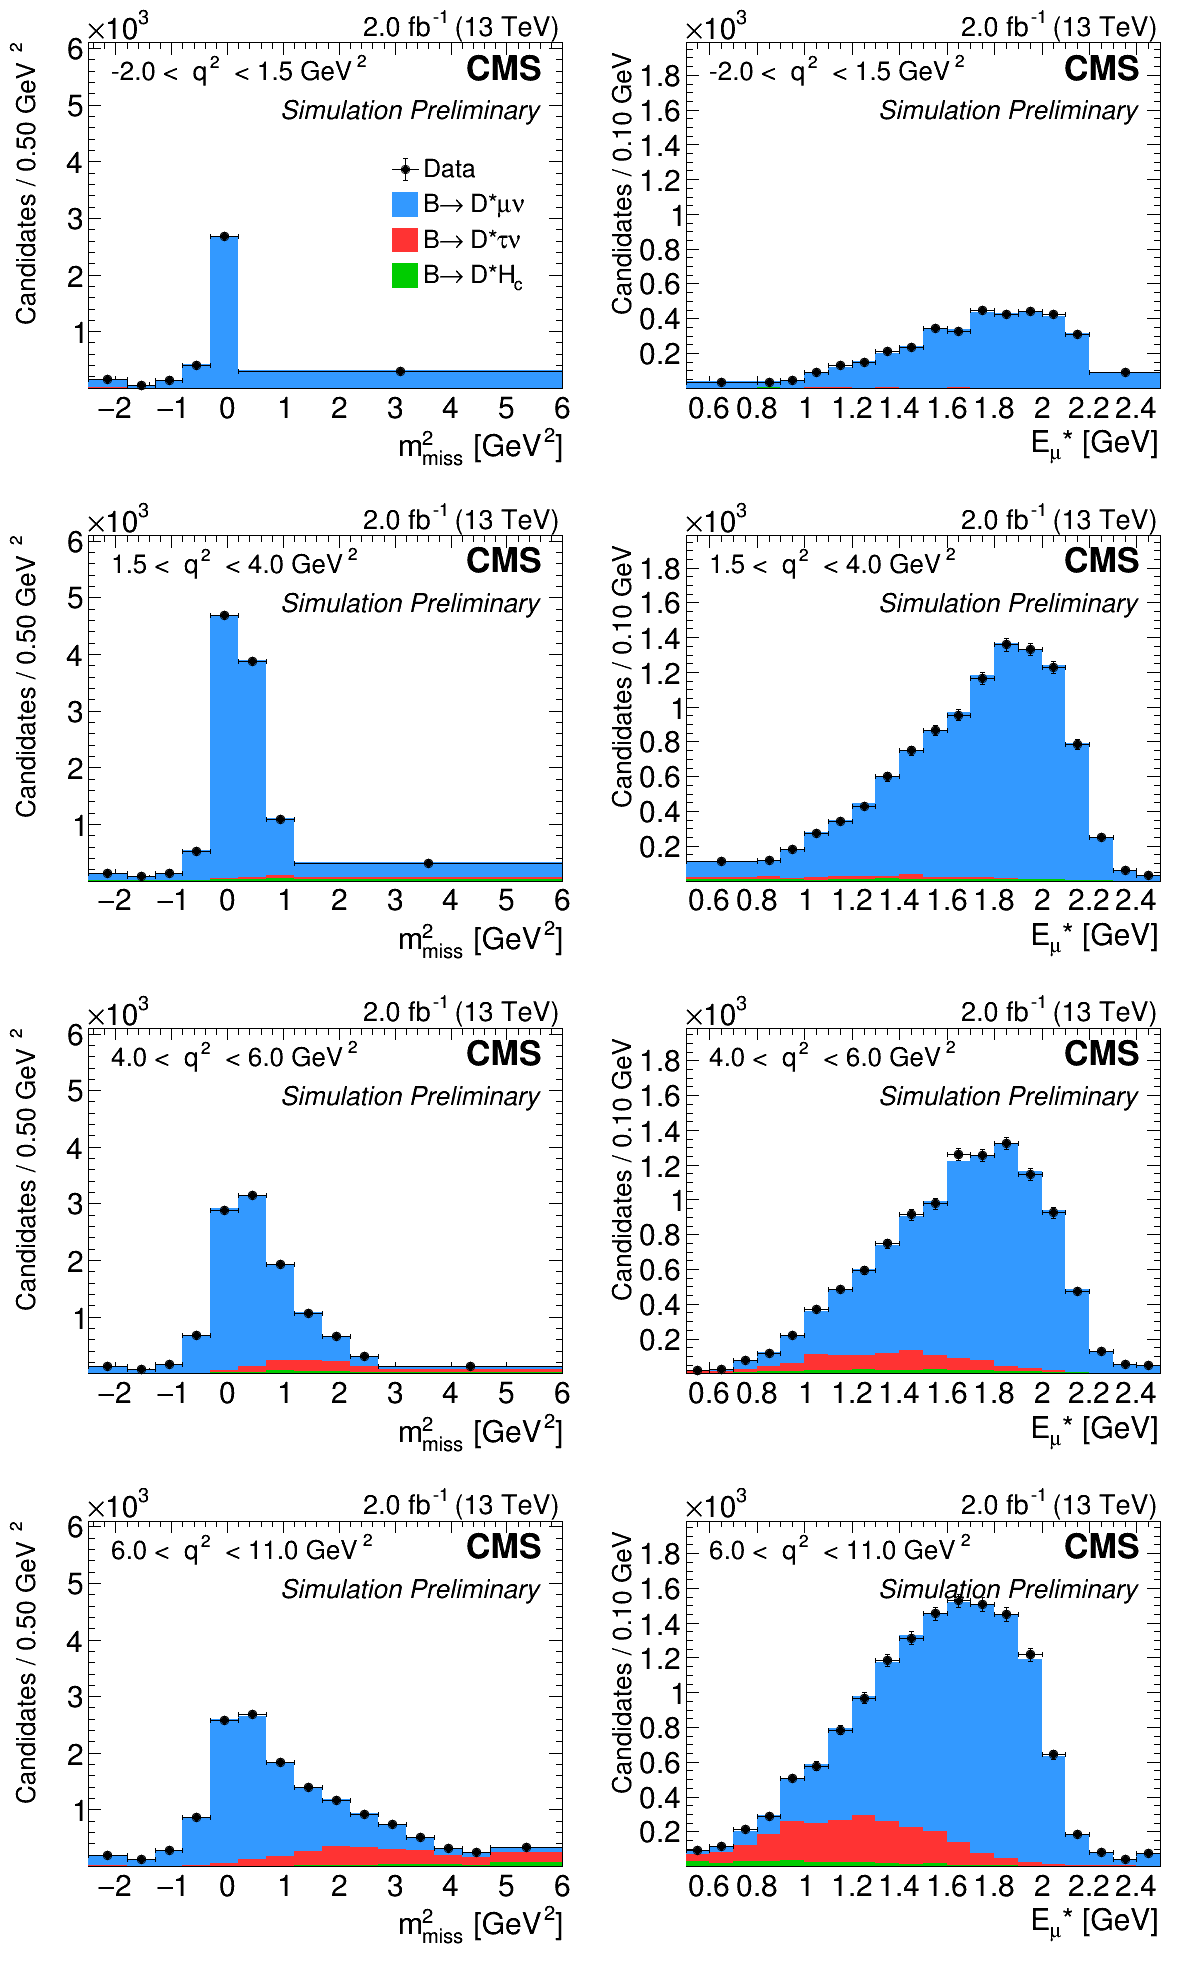

In [230]:
f = ur.open(glob(outdir + '/higgsCombine{}.FitDiagnostics.mH120.root'.format(card_name))[0])
c, d, u, _ = f['limit']['limit'].array()
print 'r = {:.1f} +{:.1f}/-{:.1f} %'.format(100*c, 100*(u-c), 100*(c-d))

N_B2mu = f['limit']['trackedParam_N_B2mu'].array()[0]
print 'N_B2mu = {:.0f}'.format(N_B2mu)
N_B2DstHc = f['limit']['trackedParam_N_B2DstHc'].array()[0]
print 'N_B2DstHc = {:.0f}'.format(N_B2DstHc)

# Get post-fit shapes
f = rt.TFile(glob(outdir + '/fitDiagnostics{}.root'.format(card_name))[0], 'READ')
print outdir + '/fitDiagnostics{}.root'.format(card_name)
fd = f.shapes_fit_s

print '\n'
histo_postfit = {}
for cat, h_dic in histo.iteritems():
    histo_postfit[cat] = {}
    for n, h in h_dic.iteritems():
        if '__' in n:
            continue
        h_post = h.Clone(h.GetName() + '_postfit')
        if not 'data' in n:
            h_fit = fd.Get(cat+'/'+n)
            for i in range(1, h_post.GetNbinsX()+1):
                h_post.SetBinContent(i, h_fit.GetBinContent(i))
                h_post.SetBinError(i, h_fit.GetBinError(i))         
        histo_postfit[cat][n] = h_post

c_out = plot_gridVarQ2(CMS_lumi, binning, histo_postfit, scale_dic={})

### Run likelyhood scan

In [120]:
# cmd = 'combine'
# cmd += ' -M MultiDimFit'
# cmd += ' --algo grid --points=500'
# cmd += ' --robustFit 1'
# cmd += ' -d ' + card_location
# cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
# cmd += ' --X-rtd MINIMIZER_analytic'
# cmd += ' --setParameters r=0.1'
# cmd += ' --rMin={} --rMax={}'.format(c - 10*(c-d), c + 10*(u-c))
# cmd += ' --trackParameters N_B2mu'
# cmd += ' -n {}'.format(card_name)
# cmd += ' --saveWorkspace'
# cmd += ' --verbose -1'

In [121]:
# print cmd
# os.system(cmd)
# os.system('mv combine_logger.out ' + outdir + '/')
# os.system('mv ./*.root ' + outdir + '/')
# os.system('mv ./*.dot ' + outdir + '/')

In [122]:
# f = ur.open(glob(outdir + '/higgsCombine{}.MultiDimFit.mH120.root'.format(card_name))[0])
# y = 2*f['limit']['deltaNLL'].array()
# x = f['limit']['r'].array()
# plt.plot(x[1:],y[1:], '.--')
# plt.xlabel('r')
# plt.ylabel(r'2$\Delta$NLL')
# r_low = interp1d(y[x < x[0]], x[x < x[0]], kind='cubic')(4.)
# r_high = interp1d(y[x > x[0]], x[x > x[0]], kind='cubic')(4.)
# y_min = np.min(y[1:])
# plt.plot(2*[r_low], [y_min, 4], 'g')
# plt.plot(2*[r_high], [y_min, 4], 'g')
# plt.plot(x, [4]*x.shape[0])
# plt.yscale('log')
# # plt.xlim(0.08, 0.11)
# print 'r = {:.3f} +{:.3f}/-{:.3f}'.format(x[0], x[0]-r_low, r_high-x[0])

### Run the pull/impact plots

Fit first the POI

In [126]:
cmd = 'combineTool.py -M Impacts --doInitialFit -m 120'
cmd += ' --robustFit 1'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r={:.2f}'.format(rawR_exp)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --verbose 0'
os.system(cmd)

0

Have POIs: ['r']
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
 minimisation of bin-wise statistical uncertainty parameters
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters

 --- MultiDimFit ---
best fit parameter values and profile-like

 Perform a similar scan for each nuisance parameter

In [128]:
cmd = 'combineTool.py -M Impacts --doFits -m 120'
cmd += ' --robustFit 1'
# cmd += ' --parallel 4'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
# cmd += ' --setParameters r={:.2f}'.format(rawR_exp)
# cmd += ' --setParameterRanges r=0.001,1'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --verbose 0'
print cmd
os.system(cmd)

combineTool.py -M Impacts --doFits -m 120 --robustFit 1 -d cards/Cat_q2var_sys_test.root -D data_obs --X-rtd MINIMIZER_analytic -n Cat_q2var_sys_test --out results/Cat_q2var_sys_test --verbose 0


256

Have POIs: ['r']
Have parameters: 117
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wi

Traceback (most recent call last):
  File "/storage/user/ocerri/work/CMSSW_10_2_13/bin/slc7_amd64_gcc700/combineTool.py", line 83, in <module>
    method.run_method()
  File "/storage/user/ocerri/work/CMSSW_10_2_13/python/CombineHarvester/CombineTools/combine/Impacts.py", line 221, in run_method
    with open(self.args.output, 'w') as out_file:
IOError: [Errno 21] Is a directory: 'results/Cat_q2var_sys_test'


Collect the results

In [136]:
cmd = 'combineTool.py -M Impacts -o impacts.json -m 120'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -n {}'.format(card_name)
print cmd
os.system(cmd);

combineTool.py -M Impacts -o impacts.json -m 120 -d cards/Cat_q2var_sys_test.root -n Cat_q2var_sys_test
Have POIs: ['r']
Have parameters: 117


In [158]:
rename = {
'B0pT': 'B_{0} p_{T} spectrum',
'N_B2mu':'N_{B#rightarrow D*#mu#nu}'
}
json.dump(rename, open('rename.json', 'w'))

cmd = 'plotImpacts.py -i impacts.json -o impacts -t rename.json'
os.system(cmd)
IFrame("impacts.pdf", width=900, height=600)

>> Doing page 0, have 30 parameters
>> Doing page 1, have 30 parameters
>> Doing page 2, have 30 parameters
>> Doing page 3, have 27 parameters


Info in <TCanvas::Print>: pdf file ./impacts.pdf has been created using the current canvas
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf and file closed


In [170]:
os.system('mv *.root {}/'.format(outdir))
os.system('mv impacts.* {}/'.format(outdir))
os.system('mv rename.json {}/'.format(outdir))
os.system('mv combine_logger.out {}/'.format(outdir));

0

### Run the Goodness of fit test

Run the observed test stat value

In [ ]:
cmd = 'combine'
cmd += ' -M GoodnessOfFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Obs'                                    # Just the output name
cmd += ' -t 0'                                      # Don't run toys
cmd += ' -s -1'                                     # Random seed
cmd += ' --toysNoSystematics --algo=saturated'
# cmd += ' --toysFrequentist'
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' --plots'
cmd += ' --verbose 9'

In [ ]:
print cmd
os.system(cmd)

Run the test stat toy distribution

In [ ]:
cmd = 'combine'
cmd += ' -M GoodnessOfFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Toys'                                   # Just the output name
cmd += ' -t 300'                                    # Number of toys to run
cmd += ' -s -1'                                     # Random seed
cmd += ' --toysNoSystematics --algo=saturated'
# cmd += ' --toysFrequentist'
# cmd += '--expectSignal=0'                           # Depending on the hypothesis to test. If none, r is fluctruated
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' --plots'
cmd += ' --verbose 1'

In [ ]:
print cmd
os.system(cmd)

Combine them to get the p-value

In [ ]:
name_obs = glob('higgsCombineObs.GoodnessOfFit.*.root')[0]
# name_obs = glob(outdir+'/higgsCombineObs.GoodnessOfFit.*.root')[0]
name_toys = glob('higgsCombineToys.GoodnessOfFit.*.root')[0]
# name_toys = glob(outdir+'/higgsCombineToys.GoodnessOfFit.*.root')[0]

In [ ]:
f = ur.open(name_obs)
s_obs = f['limit']['limit'].array()[0]

f = ur.open(name_toys)
s_toys = f['limit']['limit'].array()

content, center, _ = plt.hist(s_toys, label='Toys')
plt.plot([s_obs, s_obs], [0, np.max(content)], 'm--', label='Observed')
plt.legend(loc='best')

p_val = np.sum(s_toys > s_obs)/float(s_toys.shape[0])
print 'p-value: {:.1f}%'.format(100*p_val)
if p_val < 0.01: print p_val

In [ ]:
# cmd = 'combineTool.py'
# cmd += ' -M CollectGoodnessOfFit'
# cmd += ' --mass 120'
# cmd += ' -o gof.json'
# cmd += ' --input {} {}'.format(name_obs, name_toys)
# print cmd
# os.system(cmd)
# os.system('plotGof.py gof.json -o gof --mass 120.0')

In [ ]:
os.system('mv *.root {}/'.format(outdir))
os.system('mv *.dot {}/'.format(outdir))
os.system('mv *.out {}/'.format(outdir))